In [1]:
!pip install pandas numpy matplotlib pyarrow scikit-learn tkan temporal_linear_network scipy "jax[cuda12]" xlrd caadam -U

  Using cached numpy-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)


# Run on: NVIDIA RTX-3080 + Ryzen 5700X with cuda 12.6

In [2]:
# Standard library imports
import os
import time
from urllib.request import urlretrieve
from abc import ABC, abstractmethod

import jax
print(jax.devices())

# Set Keras backend
BACKEND = 'jax'  # You can use any backend here
os.environ['KERAS_BACKEND'] = BACKEND

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, ndimage
from scipy.ndimage import zoom
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Keras imports
import keras
from keras import ops
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.optimizers import Optimizer, Adam
from keras.applications import MobileNetV3Small
from keras.layers import Dense, GlobalAveragePooling2D
from keras.datasets import fashion_mnist, cifar10, cifar100, california_housing

from caadam import ConnectionAwareAdam, AdditiveMinMaxMedianConnectionScaling, MultiplicativeMinMaxMedianConnectionScaling, DepthConnectionScaling

[CudaDevice(id=0)]


In [3]:
N_MAX_EPOCHS = 1000
BATCH_SIZE = 64

def early_stopping_callback():
    return keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.00001,
        patience=15,
        mode="min",
        restore_best_weights=True,
        start_from_epoch=0,
    )

def lr_callback():
    return keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.25,
        patience=6,
        mode="min",
        min_delta=0.00001,
        min_lr=0.000025,
        verbose=0,
    )

def get_callbacks():
    return [early_stopping_callback(), lr_callback(), keras.callbacks.TerminateOnNaN()]

In [4]:
def resnet_block(x, filters, kernel_size=3, strides=1, conv_shortcut=False, name=None):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=strides, name=name + '_0_conv')(shortcut)
        shortcut = layers.BatchNormalization(name=name + '_0_bn')(shortcut)
    
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), name=name + '_1_conv')(x)
    x = layers.BatchNormalization(name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)
    
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), name=name + '_2_conv')(x)
    x = layers.BatchNormalization(name=name + '_2_bn')(x)
    
    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def create_resnet(input_shape, num_classes, depth=20):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (e.g., 20, 32, 44)')
    
    num_blocks = (depth - 2) // 6
    
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), name='conv1')(inputs)
    x = layers.BatchNormalization(name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    
    for i in range(3):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # first block of stages 2 and 3
                strides = 2
            x = resnet_block(x, 16 * (2**i), strides=strides, conv_shortcut=(j==0 and i>0), name=f'block{i+1}_{j+1}')
    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='classifier')(x)
    
    model = Model(inputs, x, name='resnet_cifar')
    return model

def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV3Small(input_shape=input_shape, include_top=False, weights=None)
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Unfreeze all layers for full retraining
    for layer in model.layers:
        layer.trainable = True
    
    return model

def create_mlp_model(hidden_layers, input_shape):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(1)) 
    return model

def resize_image(image, target_size):
    zoom_factors = (target_size[0] / image.shape[0], target_size[1] / image.shape[1], 1)
    return ndimage.zoom(image, zoom_factors, order=1)


def load_dataset(name):
    if name == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        # Upscale to 56x56 (2x)
        x_train = np.array([zoom(img, (2, 2)) for img in x_train])
        x_test = np.array([zoom(img, (2, 2)) for img in x_test])
        # Add channel dimension and convert to RGB for MobileNetV3
        x_train = np.stack((x_train,)*3, axis=-1) / 255.
        x_test = np.stack((x_test,)*3, axis=-1) / 255.
        # Preprocess for MobileNetV2
        x_train = keras.applications.mobilenet_v3.preprocess_input(x_train)
        x_test = keras.applications.mobilenet_v3.preprocess_input(x_test)
    elif name == 'cifar10' or name == 'cifar100':
        if name == 'cifar10':
            (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        else:
            (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
        
        # Normalize pixel values
        x_train = x_train.astype('float32') / 255.
        x_test = x_test.astype('float32') / 255.
        
        # Subtract per-pixel mean
        pixel_mean = np.mean(x_train, axis=0)
        x_train -= pixel_mean
        x_test -= pixel_mean
        
        return x_train, x_test, y_train, y_test
    elif name == 'california':
        (x_train, y_train), (x_test, y_test) = california_housing.load_data()
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        # Scale target (important for regression tasks)
        scaler_y = StandardScaler()
        y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()
        
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    return x_train, x_test, y_train, y_test

def train_and_evaluate(model, X_train, y_train, x_test, y_test, optimizer, run, is_classification=False):
    if is_classification:
        loss = 'sparse_categorical_crossentropy'
        metrics = ['accuracy']
    else:
        loss = 'mse'
        metrics = ['mae']

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=N_MAX_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        callbacks=get_callbacks(),
        verbose=0
    )
    end_time = time.time()
    
    train_time = end_time - start_time
    epochs_to_converge = len(history.history['loss'])

    if is_classification:
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        return {
            'run': run,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'train_time': train_time,
            'epochs_to_converge': epochs_to_converge,
            'history': history,
        }
    else:
        test_mse, test_mae = model.evaluate(x_test, y_test, verbose=0)
        return {
            'run': run,
            'test_rmse': np.sqrt(test_mse),
            'test_mae': test_mae,
            'train_time': train_time,
            'epochs_to_converge': epochs_to_converge,
            'history': history,
        }

# Create a color map for the optimizers
def get_color_map(optimizers):
    """
    Creates a dictionary mapping each optimizer to a distinct color
    using a qualitative colormap
    """
    colors = plt.cm.tab20(np.linspace(0, 1, len(optimizers)))
    return dict(zip(optimizers, colors))


def create_plot(results):
    dataset_name = results[0]['dataset']
    model_name = results[0]['model']
    if dataset_name == 'california':
        model_args = results[0]['model_args'][0]  # layers
        plot_name = f'{dataset_name}: {model_name} : {model_args}'
    else:
        plot_name = f'{dataset_name}: {model_name}'
    
    # Get unique optimizers and create color mapping
    all_optimizers = set([result['optimizer'] + ' ' + result['scaling_strategy'] for result in results])
    color_map = get_color_map(all_optimizers)
    
    # Define line styles for additional visual distinction
    line_styles = [
        '-',    # solid
        '--',   # dashed
        '-.',   # dash-dot
        ':',    # dotted
        (0, (3, 1, 1, 1)),  # dash-dot-dot
        (0, (5, 1)),        # dense dashed
        (0, (3, 1, 1, 1, 1, 1))  # dash-dot-dot-dot
    ]
    
    plt.figure(figsize=(12, 6))
    legend_handles = {}
    
    # Group results by optimizer for consistent styling
    grouped_results = {}
    for result in results:
        optimizer_name = result['optimizer']
        scaling_strategy = result['scaling_strategy']
        
        if optimizer_name == 'ConnectionAwareAdam':
            optimizer_name = 'CaAdam'
            if 'AdditiveMinMaxMedianConnectionScaling' in scaling_strategy:
                scaling_strategy = 'Additive'
            elif 'MultiplicativeMinMaxMedianConnectionScaling' in scaling_strategy:
                scaling_strategy = 'Multiplicative'
            elif 'DepthConnectionScaling' in scaling_strategy:
                scaling_strategy = 'Depth'
        
        optimizer = f'{optimizer_name} {scaling_strategy}'.strip()
        if optimizer not in grouped_results:
            grouped_results[optimizer] = []
        grouped_results[optimizer].append(result)
    
    # Plot each optimizer group with consistent styling
    for i, (optimizer, optimizer_results) in enumerate(grouped_results.items()):
        line_style = line_styles[i % len(line_styles)]
        base_color = color_map[optimizer_results[0]['optimizer'] + ' ' + optimizer_results[0]['scaling_strategy']]
        
        for j, result in enumerate(optimizer_results):
            # Vary transparency for multiple runs of the same optimizer
            alpha = 1.0 if len(optimizer_results) == 1 else max(0.3, 1.0 - (j * 0.15))
            
            line = plt.plot(
                result['history'].history['loss'][5:100],
                color=base_color,
                linewidth=2,
                linestyle=line_style,
                alpha=alpha
            )
            
            if optimizer not in legend_handles:
                legend_handles[optimizer] = line[0]
    
    # Create a more visible legend
    plt.legend(
        legend_handles.values(),
        legend_handles.keys(),
        loc='upper right',
        bbox_to_anchor=(0.98, 0.98),
        framealpha=0.9,
        edgecolor='black',
        fancybox=False
    )
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(plot_name)
    plt.grid(True, linestyle='--', alpha=0.4)
    
    plt.tight_layout()
    plt.savefig(plot_name + '.png', dpi=300, bbox_inches='tight')
    plt.show()

def run_loss_plot(dataset_name, start_learning_rate=0.001):
    
    mlp_hidden_layers_configs = [[64, 32], [128, 64, 32], [128, 128, 64], [256, 128, 64, 32], [128, 128, 128, 128, 128], [1024, 256, 64, 16]]
    n_runs = 5

    keras_optimizers = [
        ('Adam', lambda: optimizers.Adam(learning_rate=start_learning_rate)),
        ('AdamW', lambda: optimizers.AdamW(learning_rate=start_learning_rate)),
        ('Adamax', lambda: optimizers.Adamax(learning_rate=start_learning_rate)),
        ('Nadam', lambda: optimizers.Nadam(learning_rate=start_learning_rate)),
    ]

    connection_aware_strategies = [
        'AdditiveMinMaxMedianConnectionScaling', 'MultiplicativeMinMaxMedianConnectionScaling', 'DepthConnectionScaling',
    ]

    print(f'On dataset: {dataset_name}')
    X_train, X_test, y_train, y_test = load_dataset(dataset_name)
    
    if dataset_name == 'fashion_mnist':
        model_configs = [('ResNet20', create_resnet, (56, 56, 3), 10)]
        is_classification = True
    elif dataset_name == 'cifar10' or dataset_name == 'cifar100':
        num_classes = 10 if dataset_name == 'cifar10' else 100
        model_configs = [('ResNet20', create_resnet, (32, 32, 3), num_classes)]
        is_classification = True
    else:  # california
        model_configs = [('MLP', create_mlp_model, hidden_layers, X_train.shape[1:]) for hidden_layers in mlp_hidden_layers_configs]
        is_classification = False

    for model_name, model_func, *model_args in model_configs:
        print(f'Using model: {model_name}')

        results = []
        
        for run in range(n_runs):
            print(f'Run: {run + 1}/{n_runs}')
            
            initial_model = model_func(*model_args)
            initial_weights = initial_model.get_weights()
            
            # Keras optimizers
            for opt_name, opt_func in keras_optimizers:
                model = keras.models.clone_model(initial_model)
                model.set_weights(initial_weights)
                optimizer = opt_func()
                result = train_and_evaluate(model, X_train, y_train, X_test, y_test, optimizer, run, is_classification)
                
                result.update({
                    'dataset': dataset_name,
                    'model': model_name,
                    'optimizer': opt_name,
                    'model_args': model_args,
                    'scaling_strategy': '',
                    'scaling_factor': ''
                })
                print(result)
                results.append(result)
                del model

            # ConnectionAwareAdam
            for strategy_name in connection_aware_strategies:
                model = keras.models.clone_model(initial_model)
                model.set_weights(initial_weights)
                
                if strategy_name == 'AdditiveMinMaxMedianConnectionScaling':
                    strategy = AdditiveMinMaxMedianConnectionScaling()
                elif strategy_name == 'MultiplicativeMinMaxMedianConnectionScaling':
                    strategy = MultiplicativeMinMaxMedianConnectionScaling()
                elif strategy_name == 'DepthConnectionScaling':
                    strategy = DepthConnectionScaling()
                
                optimizer = ConnectionAwareAdam(learning_rate=start_learning_rate, scaling_strategy=strategy)
                result = train_and_evaluate(model, X_train, y_train, X_test, y_test, optimizer, run, is_classification)
                result.update({
                    'dataset': dataset_name,
                    'model': model_name,
                    'optimizer': 'ConnectionAwareAdam',
                    'scaling_strategy': strategy_name,
                    'model_args': model_args,
                })
                print(result)
                results.append(result)
                del model
        create_plot(results)
        del results


On dataset: california
Using model: MLP
Run: 1/5
{'run': 0, 'test_rmse': np.float64(0.4632202938177378), 'test_mae': 0.3107970356941223, 'train_time': 14.17836308479309, 'epochs_to_converge': 100, 'history': <keras.src.callbacks.history.History object at 0x7bcde7fa1b40>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'Adam', 'model_args': [[64, 32], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.465765575975718), 'test_mae': 0.3132380247116089, 'train_time': 12.613481521606445, 'epochs_to_converge': 95, 'history': <keras.src.callbacks.history.History object at 0x7bcde5a419c0>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'AdamW', 'model_args': [[64, 32], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.4802396739929871), 'test_mae': 0.3263278007507324, 'train_time': 15.45489764213562, 'epochs_to_converge': 117, 'history': <keras.src.callbacks.history.History object at 0x7bcde593bfa0>, 'd

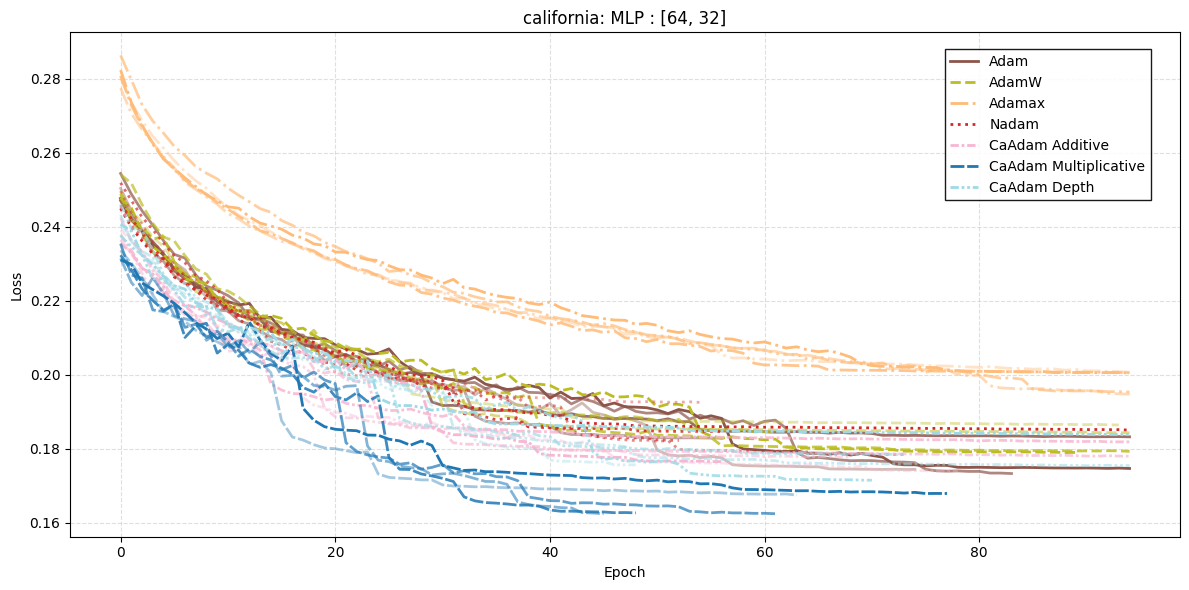

Using model: MLP
Run: 1/5
{'run': 0, 'test_rmse': np.float64(0.4512209844903117), 'test_mae': 0.29713040590286255, 'train_time': 13.137110471725464, 'epochs_to_converge': 81, 'history': <keras.src.callbacks.history.History object at 0x7bcd8de37d00>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'Adam', 'model_args': [[128, 64, 32], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.4531575059741152), 'test_mae': 0.2997841238975525, 'train_time': 11.543892621994019, 'epochs_to_converge': 74, 'history': <keras.src.callbacks.history.History object at 0x7bcd8d91add0>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'AdamW', 'model_args': [[128, 64, 32], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.4627707120844594), 'test_mae': 0.3116655945777893, 'train_time': 21.97371220588684, 'epochs_to_converge': 162, 'history': <keras.src.callbacks.history.History object at 0x7bcd8d8692a0>, 'dataset': 'c

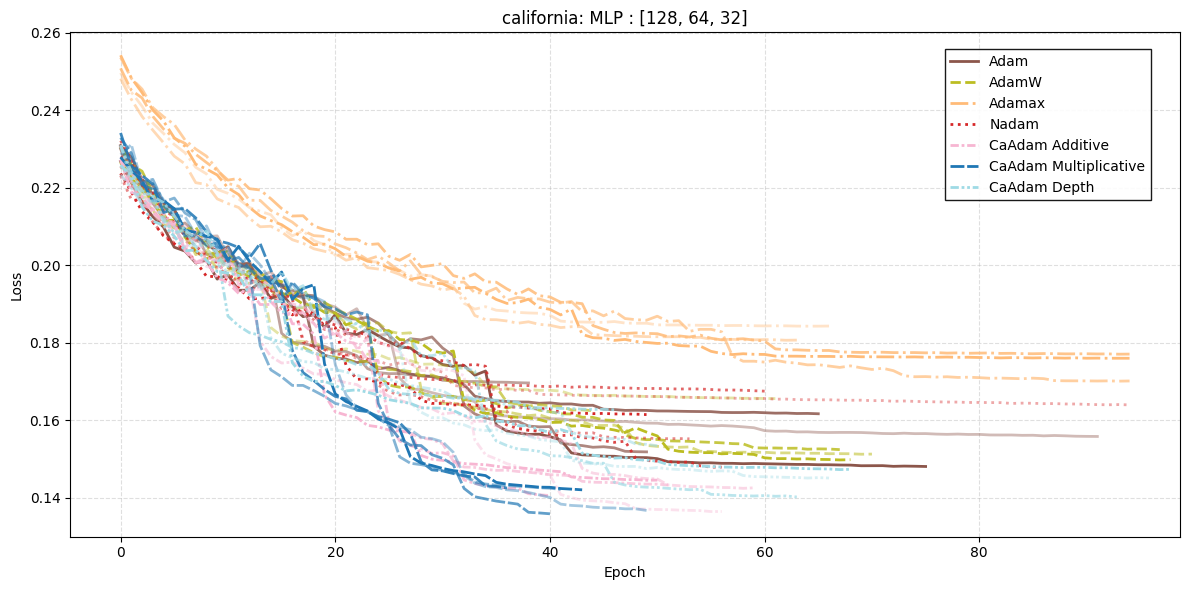

Using model: MLP
Run: 1/5
{'run': 0, 'test_rmse': np.float64(0.4533970115036443), 'test_mae': 0.30050045251846313, 'train_time': 9.195068836212158, 'epochs_to_converge': 45, 'history': <keras.src.callbacks.history.History object at 0x7bcdcc0e4580>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'Adam', 'model_args': [[128, 128, 64], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.4499529105291032), 'test_mae': 0.29599371552467346, 'train_time': 9.78907823562622, 'epochs_to_converge': 63, 'history': <keras.src.callbacks.history.History object at 0x7bcdccb792a0>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'AdamW', 'model_args': [[128, 128, 64], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.4636043406203493), 'test_mae': 0.311771959066391, 'train_time': 8.765950679779053, 'epochs_to_converge': 57, 'history': <keras.src.callbacks.history.History object at 0x7bcd841c3910>, 'dataset': 'cal

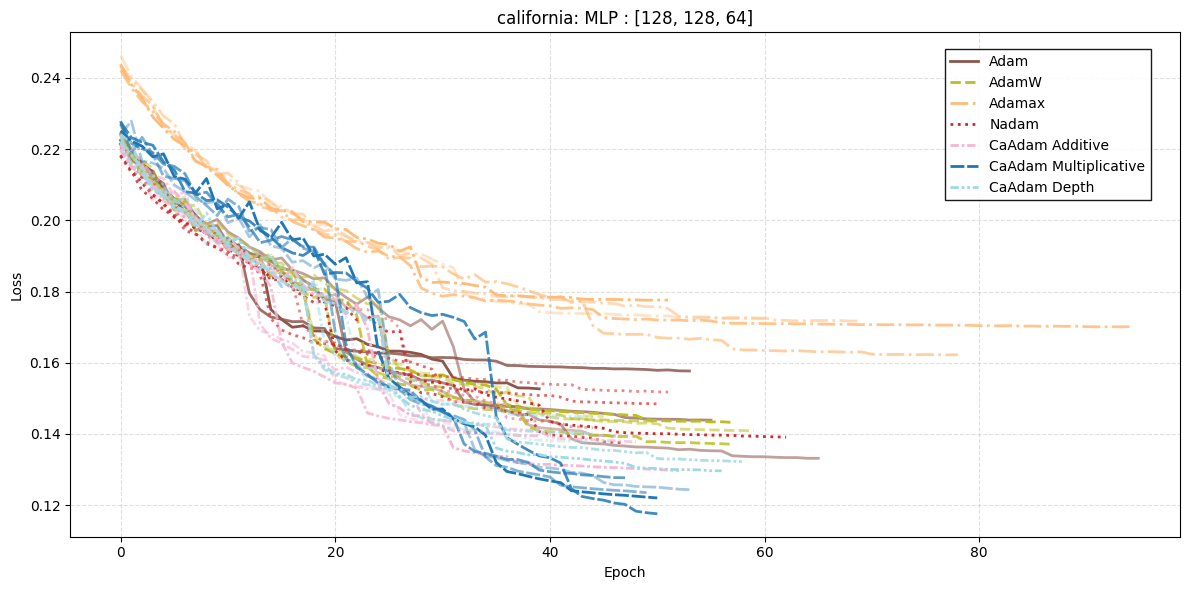

Using model: MLP
Run: 1/5
{'run': 0, 'test_rmse': np.float64(0.44633981094806924), 'test_mae': 0.2902355492115021, 'train_time': 11.804019689559937, 'epochs_to_converge': 53, 'history': <keras.src.callbacks.history.History object at 0x7bcd8d926080>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'Adam', 'model_args': [[256, 128, 64, 32], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.4442246014628613), 'test_mae': 0.29004064202308655, 'train_time': 9.695647239685059, 'epochs_to_converge': 53, 'history': <keras.src.callbacks.history.History object at 0x7bcd9d625510>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'AdamW', 'model_args': [[256, 128, 64, 32], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.45904407518778806), 'test_mae': 0.30756425857543945, 'train_time': 10.700374364852905, 'epochs_to_converge': 60, 'history': <keras.src.callbacks.history.History object at 0x7bcd9de03700>, '

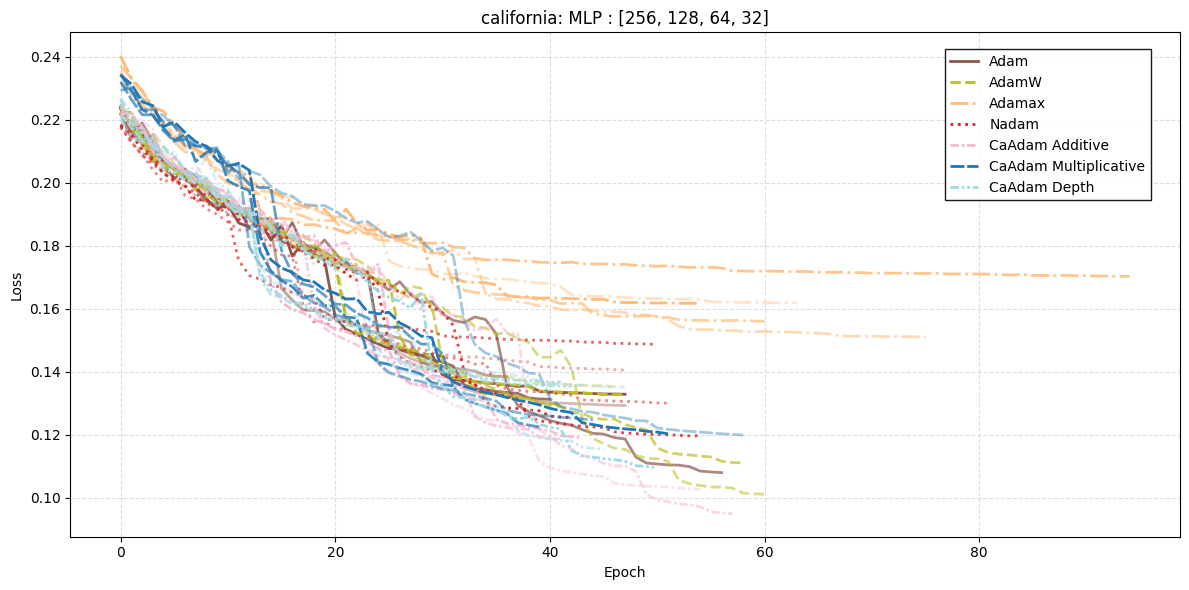

Using model: MLP
Run: 1/5
{'run': 0, 'test_rmse': np.float64(0.4523714969538378), 'test_mae': 0.2981053590774536, 'train_time': 6.746169567108154, 'epochs_to_converge': 38, 'history': <keras.src.callbacks.history.History object at 0x7bcd7f4edb10>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'Adam', 'model_args': [[128, 128, 128, 128, 128], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.4475059696417359), 'test_mae': 0.2867659032344818, 'train_time': 9.228863000869751, 'epochs_to_converge': 54, 'history': <keras.src.callbacks.history.History object at 0x7bcd7eb46710>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'AdamW', 'model_args': [[128, 128, 128, 128, 128], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.45870565514526657), 'test_mae': 0.3043534755706787, 'train_time': 9.066803932189941, 'epochs_to_converge': 57, 'history': <keras.src.callbacks.history.History object at 0x7bcd7f2

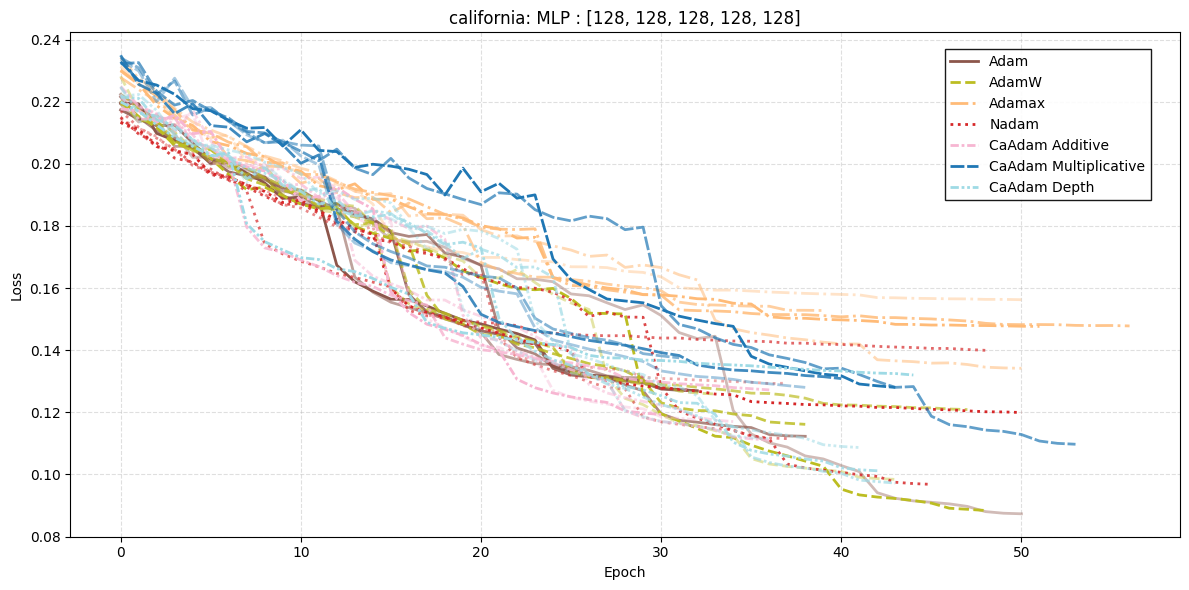

Using model: MLP
Run: 1/5
{'run': 0, 'test_rmse': np.float64(0.4451144263134589), 'test_mae': 0.2901661992073059, 'train_time': 15.02533769607544, 'epochs_to_converge': 64, 'history': <keras.src.callbacks.history.History object at 0x7bcd9d5333d0>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'Adam', 'model_args': [[1024, 256, 64, 16], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.4453047366887714), 'test_mae': 0.2888287603855133, 'train_time': 10.31690788269043, 'epochs_to_converge': 57, 'history': <keras.src.callbacks.history.History object at 0x7bcdd8d9fb50>, 'dataset': 'california', 'model': 'MLP', 'optimizer': 'AdamW', 'model_args': [[1024, 256, 64, 16], (8,)], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_rmse': np.float64(0.4514811227987943), 'test_mae': 0.29583996534347534, 'train_time': 12.836130619049072, 'epochs_to_converge': 73, 'history': <keras.src.callbacks.history.History object at 0x7bcde5ab2e60>, 'da

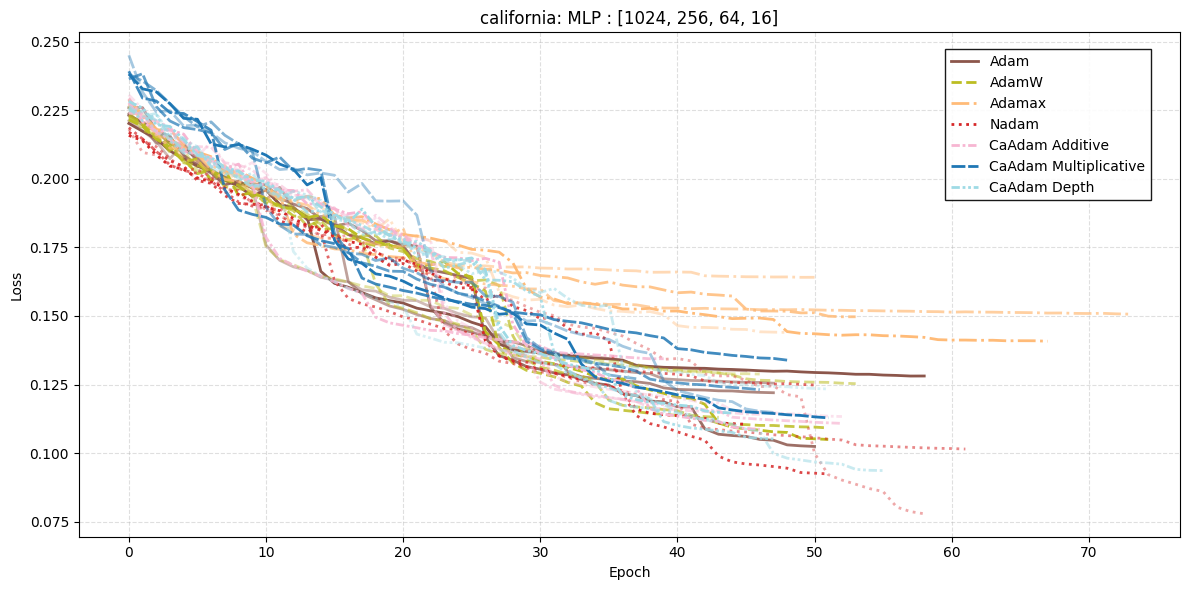

In [5]:
run_loss_plot('california')

On dataset: fashion_mnist
Using model: ResNet20
Run: 1/5
{'run': 0, 'test_accuracy': 0.9288000464439392, 'test_loss': 0.29343679547309875, 'train_time': 241.96864438056946, 'epochs_to_converge': 27, 'history': <keras.src.callbacks.history.History object at 0x7bcd7ed788e0>, 'dataset': 'fashion_mnist', 'model': 'ResNet20', 'optimizer': 'Adam', 'model_args': [(56, 56, 3), 10], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_accuracy': 0.9252000451087952, 'test_loss': 0.3497627079486847, 'train_time': 334.1355519294739, 'epochs_to_converge': 38, 'history': <keras.src.callbacks.history.History object at 0x7bcd841a9a80>, 'dataset': 'fashion_mnist', 'model': 'ResNet20', 'optimizer': 'AdamW', 'model_args': [(56, 56, 3), 10], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_accuracy': 0.9187000393867493, 'test_loss': 0.3525264859199524, 'train_time': 240.6665301322937, 'epochs_to_converge': 27, 'history': <keras.src.callbacks.history.History object at 0x7bcd9d6ac760

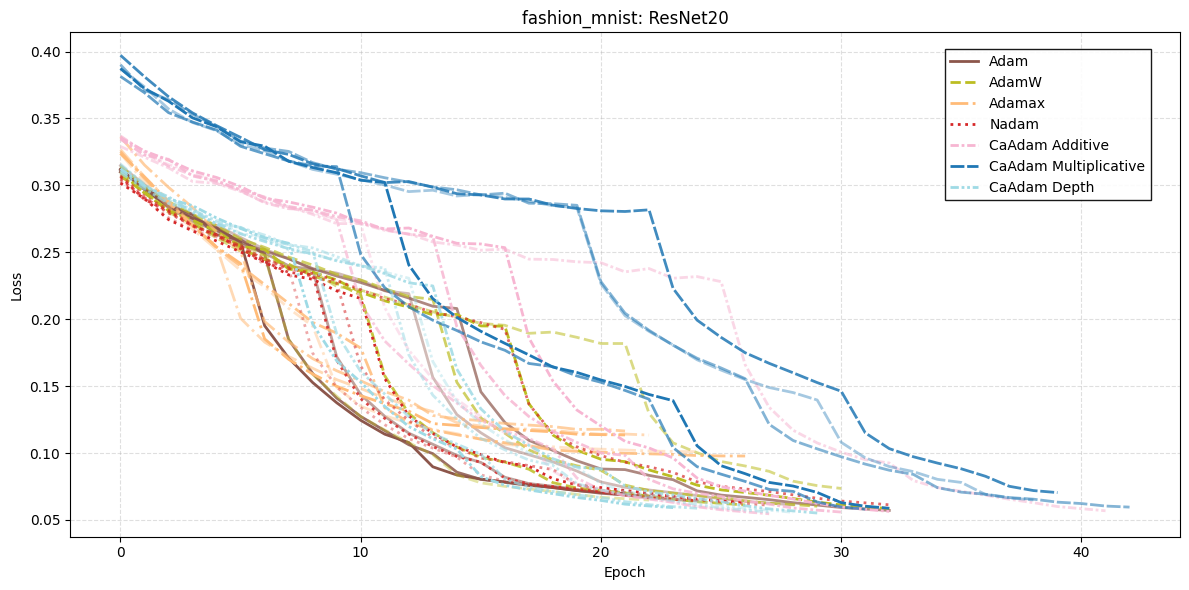

In [6]:
run_loss_plot('fashion_mnist')

On dataset: cifar10
Using model: ResNet20
Run: 1/5
{'run': 0, 'test_accuracy': 0.7973000407218933, 'test_loss': 0.8266457319259644, 'train_time': 98.77414536476135, 'epochs_to_converge': 27, 'history': <keras.src.callbacks.history.History object at 0x7bcd7bfd1390>, 'dataset': 'cifar10', 'model': 'ResNet20', 'optimizer': 'Adam', 'model_args': [(32, 32, 3), 10], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_accuracy': 0.7952000498771667, 'test_loss': 0.9031853675842285, 'train_time': 98.22805619239807, 'epochs_to_converge': 29, 'history': <keras.src.callbacks.history.History object at 0x7bcd2927b310>, 'dataset': 'cifar10', 'model': 'ResNet20', 'optimizer': 'AdamW', 'model_args': [(32, 32, 3), 10], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_accuracy': 0.6742000579833984, 'test_loss': 1.0760596990585327, 'train_time': 76.70746183395386, 'epochs_to_converge': 22, 'history': <keras.src.callbacks.history.History object at 0x7bcd35c50370>, 'dataset': 'cifar

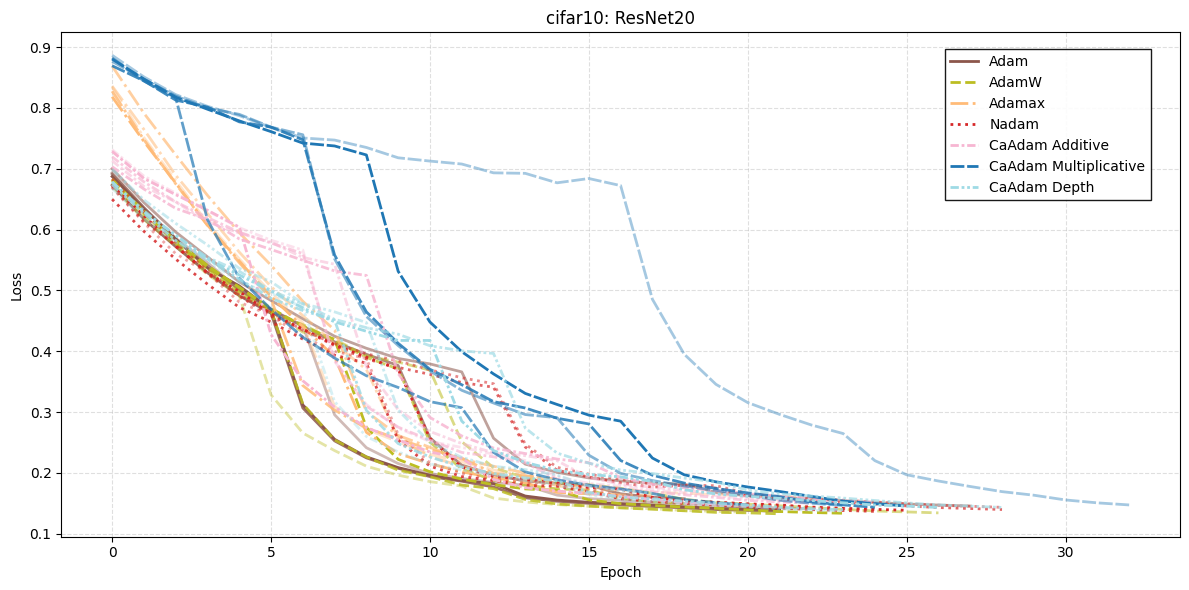

In [7]:
run_loss_plot('cifar10')

On dataset: cifar100
Using model: ResNet20
Run: 1/5
{'run': 0, 'test_accuracy': 0.4742000102996826, 'test_loss': 2.4426419734954834, 'train_time': 116.80725193023682, 'epochs_to_converge': 35, 'history': <keras.src.callbacks.history.History object at 0x7bcd7f1c68c0>, 'dataset': 'cifar100', 'model': 'ResNet20', 'optimizer': 'Adam', 'model_args': [(32, 32, 3), 100], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_accuracy': 0.4869000315666199, 'test_loss': 2.2787487506866455, 'train_time': 113.42616558074951, 'epochs_to_converge': 34, 'history': <keras.src.callbacks.history.History object at 0x7bcdd821c310>, 'dataset': 'cifar100', 'model': 'ResNet20', 'optimizer': 'AdamW', 'model_args': [(32, 32, 3), 100], 'scaling_strategy': '', 'scaling_factor': ''}
{'run': 0, 'test_accuracy': 0.39430001378059387, 'test_loss': 2.5615451335906982, 'train_time': 127.48309683799744, 'epochs_to_converge': 39, 'history': <keras.src.callbacks.history.History object at 0x7bcda8bbbd60>, 'dataset

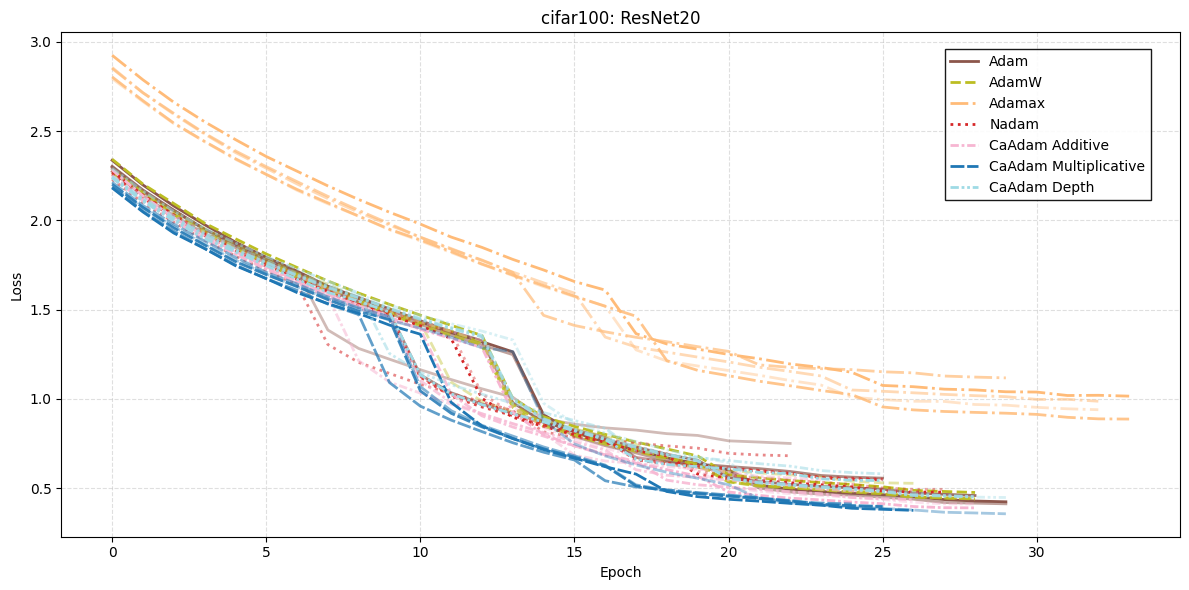

In [9]:
run_loss_plot('cifar100')